In [48]:
import torch
import torch.nn as nn
from torch.nn import ReLU, Sequential, MSELoss, Linear
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [49]:
path = '~\downloads\lfw\lfw'

In [50]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [51]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

MPS device not found.


torch.Size([250, 250, 3])


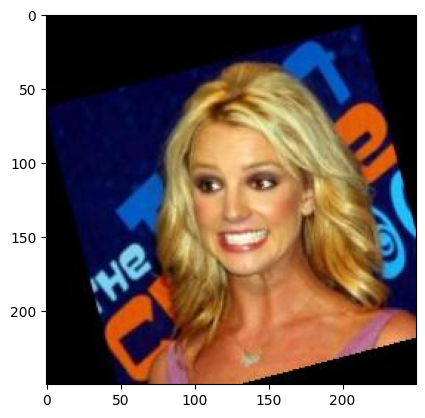

In [52]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [53]:
for x,y in dataloader:
    print(x[0].shape)
    break
#the meaning for each dimension is: channel, height, and width. Height and width can be assume both numbers correspond with the size/range of numbers 
#of the picture above for x and y (250). Channel acts like the color of the image. In this case, it appears to be RGB as the 3 channels, as the picture
#above is represented in colors and RGB is 3 values to control.

torch.Size([3, 250, 250])


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [171]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()
        base=16
        self.encode = Sequential(
            nn.Conv2d(3, base,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(base,base*2,3,padding=1,stride=2),
            nn.ReLU(),
            nn.Conv2d(base*2,base*2,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(base*2,base*4,3,padding=1,stride=2),
            nn.ReLU(),
            nn.Conv2d(base*4,base*4,3,padding=1),
            nn.ReLU()
            #nn.Flatten(),
            #nn.Linear(2*base*125*125,250),
        )
        self.decode = Sequential(
            #nn.Linear(250,2*base*125*125),
            #nn.Unflatten(-1,(2*base,125,125)),
            #nn.ReLU(),
            nn.ConvTranspose2d(4*base,4*base,3,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4*base,2*base,3,stride=2,padding=1,output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(2*base,2*base,3,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2*base,base,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(base,3,3,padding=1),
        )

    def encoder(self,x):
        return self.encode(x)
        
    def decoder(self,x):
        return self.decode(x)
        
    def forward(self,x):
        return self.decode(self.encode(x))

       

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [172]:
model = AE()

In [173]:

for x,y in dataloader:
    #checks for one image
    print("Initial:")
    print(x.shape)
    temp_x = x
    print("\nInitial Reshape:")
    print(temp_x.shape)
    encoded = model.encoder(temp_x)
    print("\nEncoded:")
    print(encoded.shape)
    decoded = model.decoder(encoded)
    print("\nDecoded Original Shape:")
    print(decoded.shape)
    print("\nForward Original Shape:")
    print((model(temp_x)*250).shape)
    break

Initial:
torch.Size([32, 3, 250, 250])

Initial Reshape:
torch.Size([32, 3, 250, 250])

Encoded:
torch.Size([32, 64, 63, 63])

Decoded Original Shape:
torch.Size([32, 3, 250, 250])

Forward Original Shape:
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [174]:
#numel gets number of parameter in the layer p
sum(p.numel() for p in list(model.parameters()))

139459

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [175]:
#the cell to fully train the model;uses all of the training set
size = len(dataloader.dataset)
model = AE()
model.train()
learning_rate = 1e-3
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
epoch = 5
for t in range(epoch):
    total_loss = 0
    count = 0
    print(f"Epoch {t+1}\n-------------------------------")
    for batch, (x,y) in enumerate(dataloader):
        pred_x = model(x)
        loss = loss_function(pred_x, x)
        optim.zero_grad()
        loss.backward(retain_graph=True)
        optim.step()
        total_loss += loss.item()
        current = (batch+1)* len(x)
        #13237%32 is 413.65, so I assume the 412th image is close to the last picture
        if count % 100 == 0 or count == 412:
            print(f"MSE loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        count += 1
    total_loss/=count
    print(f" Avg MSE loss: {total_loss:>8f} \n")

Epoch 1
-------------------------------
MSE loss: 0.192600  [   32/13237]
MSE loss: 0.008913  [ 3232/13237]
MSE loss: 0.004993  [ 6432/13237]
MSE loss: 0.003393  [ 9632/13237]
MSE loss: 0.002003  [12832/13237]
MSE loss: 0.001810  [13216/13237]
 Avg MSE loss: 0.012128 

Epoch 2
-------------------------------
MSE loss: 0.002005  [   32/13237]
MSE loss: 0.001542  [ 3232/13237]
MSE loss: 0.001182  [ 6432/13237]
MSE loss: 0.001264  [ 9632/13237]
MSE loss: 0.001371  [12832/13237]
MSE loss: 0.001180  [13216/13237]
 Avg MSE loss: 0.001552 

Epoch 3
-------------------------------
MSE loss: 0.001020  [   32/13237]
MSE loss: 0.000593  [ 3232/13237]
MSE loss: 0.000823  [ 6432/13237]
MSE loss: 0.000786  [ 9632/13237]
MSE loss: 0.000596  [12832/13237]
MSE loss: 0.000671  [13216/13237]
 Avg MSE loss: 0.001100 

Epoch 4
-------------------------------
MSE loss: 0.000609  [   32/13237]
MSE loss: 0.000486  [ 3232/13237]
MSE loss: 0.000436  [ 6432/13237]
MSE loss: 0.000560  [ 9632/13237]
MSE loss: 0.00

In [179]:
#My loss during the training loop decreases. If the situation was that my loss were to not decrease anymore, or if they were to instead to increase
#then I would consider changing the learning rate to be lower so that the training does not go over the minimum, or adjust the layers of my model, 
#specifically decreasing the amount of layers that reduces dimensions. Since each layer that reduces dimension makes the output have less reliance
#on the source input, removing some of these layers will mean that the latent output will have more information on the original source input.
#So if the model is not training well, I would need to balance out the number of layers to ensure that I get the latent space with the least total 
#dimension while also having an effective model that can still accurately predict the input image.
#If I use the linear layer/bottleneck for the model and condense the latent space to a size of 200, I get a smaller latent dimension, but the model
#training no longer become efficient/able to predict the input image. In this case, the model's training loss actually goes up after a few epoch.
#In this case, I believe that the problem is due to I do not implement a smoother transition down to 200, since the original size of the image is 
#3*250*250 and the Conv2d layers implemented is still not enough to bring it close to 200. I infer that alot of information is loss due to this force
#compression. So in this case if I do use a linear bottleneck, I want to include more layers before the linear compression to 200 that compresses/
#removes dimension more steadily so that the informations do not get loss without being learned. I would say that a problem with adding more layers
#is that it does add more complexity and parameters to the model, and hence more computation power that would be limited by the computer and its specs.
#One method I could have used in my model to combat this computation power is to introduce pooling, which I do not, into the model. Some parts of the.
#initial data may be loss but the dimensionality becomes much lower and makes it easier for the linear layer. I could implement pooling, possibly not
#max pooling as changes in data that are not the max get loss, after every conv layer or my sparsely.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


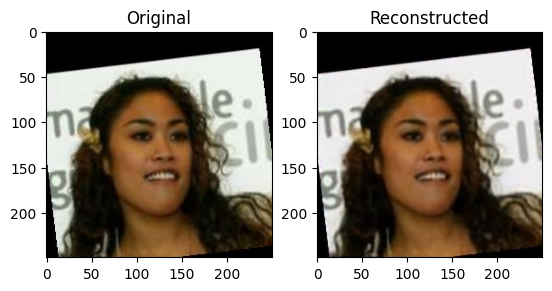

In [176]:
model.eval()
_, axarr = plt.subplots(1,2) 
for x,y in dataloader:
    temp = model(x)[0].permute(1,2,0)
    axarr[1].title.set_text("Reconstructed")
    axarr[1].imshow(temp.detach().numpy())
    axarr[0].title.set_text("Original")
    axarr[0].imshow(x[0].permute(1,2,0))
    break

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


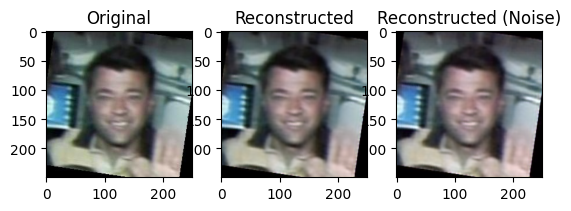

In [189]:
model.eval()
_, axarr = plt.subplots(1,3) 
for x,y in dataloader:
    temp_encode = model.encode(x)
    temp_encode += torch.Tensor(np.random.normal(5.0e-02,2.0e-02,temp_encode.shape))
    temp = model.decode(temp_encode)[0].permute(1,2,0)
    axarr[1].title.set_text("Reconstructed")
    axarr[1].imshow(model(x)[0].permute(1,2,0).detach().numpy())
    axarr[2].title.set_text("Reconstructed (Noise)")
    axarr[2].imshow(temp.detach().numpy())
    axarr[0].title.set_text("Original")
    axarr[0].imshow(x[0].permute(1,2,0))
    break
#The noise on the latent representation is affecting the brightness/saturation of the image. The image appears to look alot brighter as the noise 
#increases. If the noise is too high however, the original image it derives from no longer become comprehensible. With less noise, the image get less
#brighter and eventually becomes the original predicted input from the model. I will note that a small normaly distributed noise (like the one used 
#above) makes the reconstructed image look almost unaffected. So the noise on the latent will need to be somewhat high/signficant for the 
#reconstructed input to seem affected/brighter.